In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (root_mean_squared_error, r2_score, 
                             mean_absolute_error, mean_squared_error)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

np.random.seed(42)
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('car-details.csv')
df.sample(5)

,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
6878,Toyota Innova 2.5 E 7 STR,Toyota,Innova,2.5 E 7 STR,2009,First,Diesel,Individual,Manual,250000,30.08,2494.0,102.00,200.05566,7.0,550000
3660,Mahindra XUV500 W10 2WD,Mahindra,XUV500,W10 2WD,2015,First,Diesel,Dealer,Manual,39000,37.60,2179.0,140.00,330.00000,7.0,1225000
5604,Ford EcoSport 1.5 Diesel Titanium BSIV,Ford,EcoSport,1.5 Diesel Titanium BSIV,2018,First,Diesel,Individual,Manual,90000,54.06,1498.0,98.96,205.00000,5.0,850000
3806,Maruti Wagon R LX BSIII,Maruti,Wagon,R LX BSIII,2008,Third,Petrol,Individual,Manual,100000,40.66,1061.0,64.00,84.33719,5.0,80000
2338,Honda Amaze VX i-DTEC,Honda,Amaze,VX i-DTEC,2018,First,Diesel,Individual,Manual,40000,60.62,1498.0,98.60,200.00000,5.0,825000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   company        6926 non-null   object 
 2   model          6926 non-null   object 
 3   edition        6926 non-null   object 
 4   year           6926 non-null   int64  
 5   owner          6926 non-null   object 
 6   fuel           6926 non-null   object 
 7   seller_type    6926 non-null   object 
 8   transmission   6926 non-null   object 
 9   km_driven      6926 non-null   int64  
 10  mileage_mpg    6718 non-null   float64
 11  engine_cc      6718 non-null   float64
 12  max_power_bhp  6717 non-null   float64
 13  torque_nm      6717 non-null   float64
 14  seats          6718 non-null   float64
 15  selling_price  6926 non-null   int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 865.9+ KB


In [7]:
df.isna().sum()

name               0
company            0
model              0
edition            0
year               0
owner              0
fuel               0
seller_type        0
transmission       0
km_driven          0
mileage_mpg      208
engine_cc        208
max_power_bhp    209
torque_nm        209
seats            208
selling_price      0
dtype: int64

In [8]:
df.shape

(6926, 16)

In [9]:
for col in df.select_dtypes(include='O').columns:
    print(f'Column: {col}')
    print(f'Cardinality: {df[col].nunique()}')
    print(df[col].unique())
    print(df[col].value_counts(normalize=True))
    print()

Column: name
Cardinality: 2058
['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']
name
Maruti Swift Dzire VDI                          0.017037
Maruti Alto 800 LXI                             0.010973
Maruti Alto LXi                                 0.009962
Maruti Swift VDI                                0.008663
Maruti Swift VDI BSIV                           0.008085
                                                  ...   
Ford EcoSport 1.5 TDCi Titanium Plus BE BSIV    0.000144
Ford Figo 1.5 Sports Edition MT                 0.000144
Volkswagen Polo Select 1.2 MPI Highline         0.000144
Honda Jazz V Diesel                             0.000144
Renault Duster RXZ 110PS AMT BSIV               0.000144
Name: proportion, Length: 2058, dtype: float64

Column: company
Cardinality: 32
['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota' '

In [10]:
df = df.drop(columns=['name', 'model', 'edition'])
df.head()

,company,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


In [11]:
df = df.drop_duplicates()
df.head()

,company,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
0,Maruti,2014,First,Diesel,Individual,Manual,145500,55.00,1248.0,74.00,190.000000,5.0,450000
1,Skoda,2014,Second,Diesel,Individual,Manual,120000,49.70,1498.0,103.52,250.000000,5.0,370000
2,Honda,2006,Third,Petrol,Individual,Manual,140000,41.60,1497.0,78.00,124.544455,5.0,158000
3,Hyundai,2010,First,Diesel,Individual,Manual,127000,54.06,1396.0,90.00,219.668960,5.0,225000
4,Maruti,2007,First,Petrol,Individual,Manual,120000,37.84,1298.0,88.20,112.776475,5.0,130000


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
X = df.drop(columns='selling_price')
y = df['selling_price'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (6907, 12)
Target shape: (6907,)


In [14]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [col for col in X.columns if col not in num_cols]

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'seats']
Categorical columns: ['company', 'owner', 'fuel', 'seller_type', 'transmission']


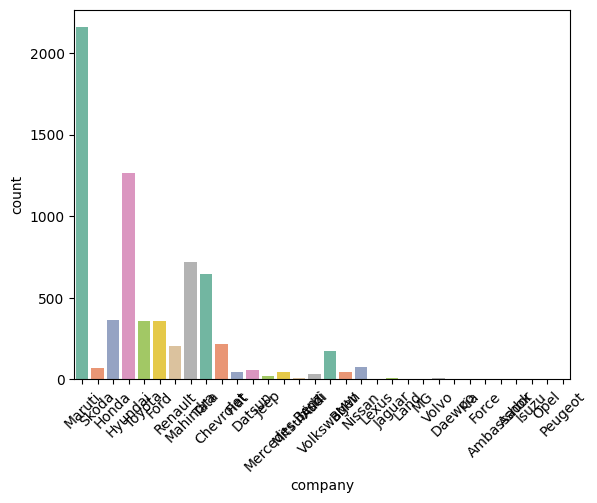

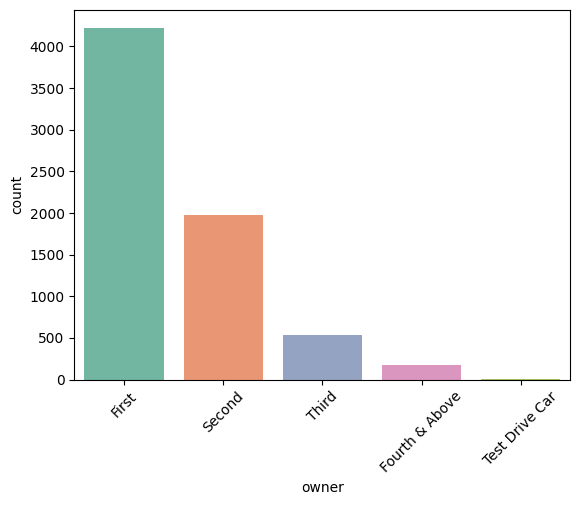

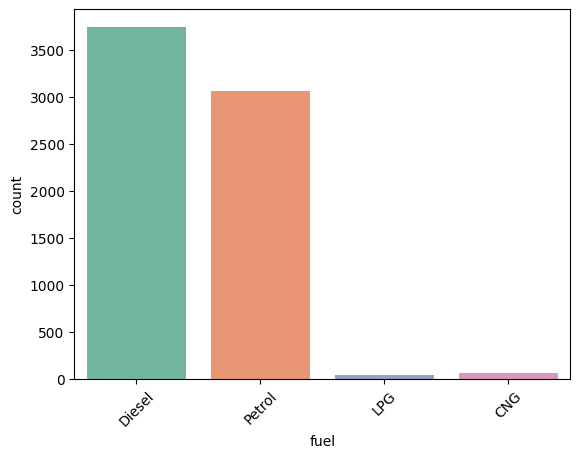

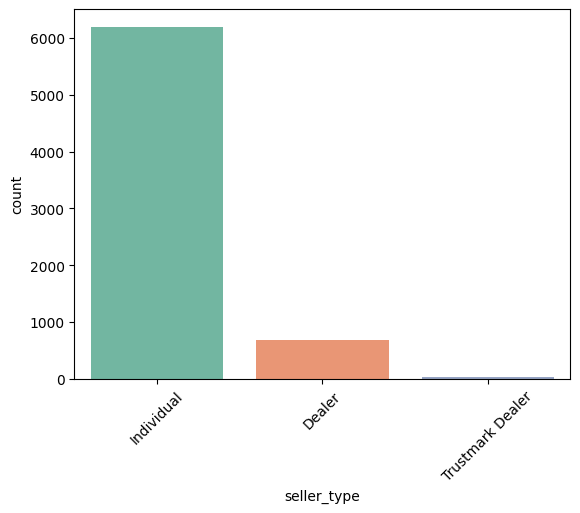

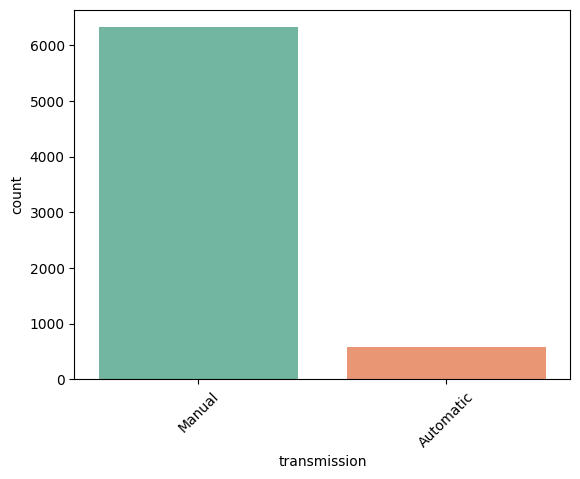

In [15]:
for col in cat_cols:
    sns.countplot(x = col, data=df, palette="Set2", hue = col, legend=False)
    plt.xticks(rotation=45)
    plt.show(block=True)

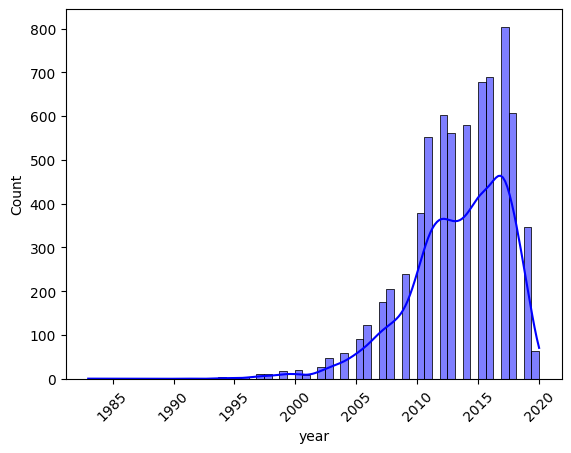

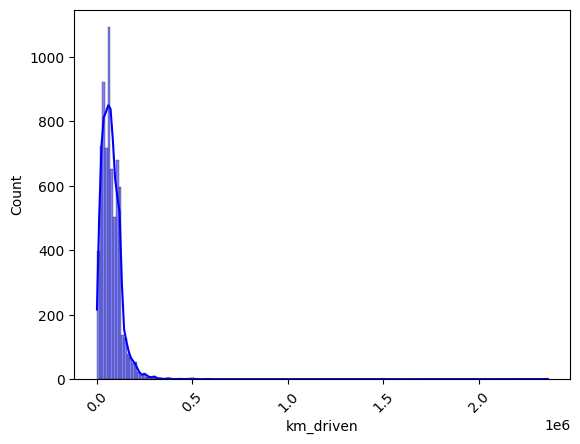

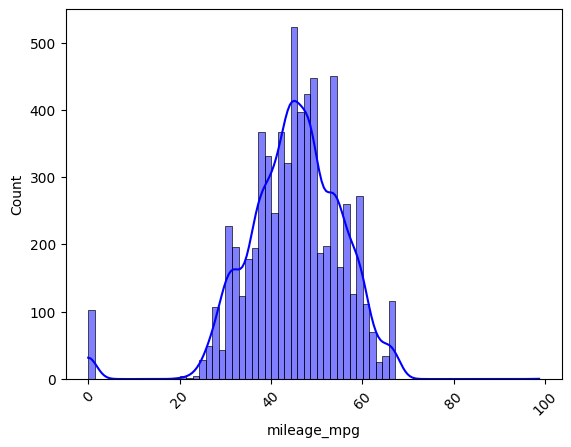

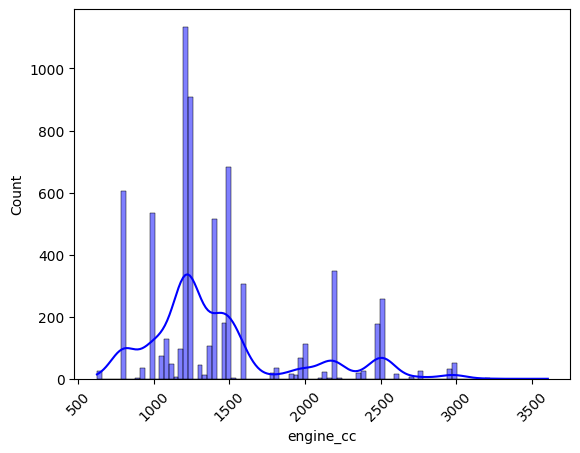

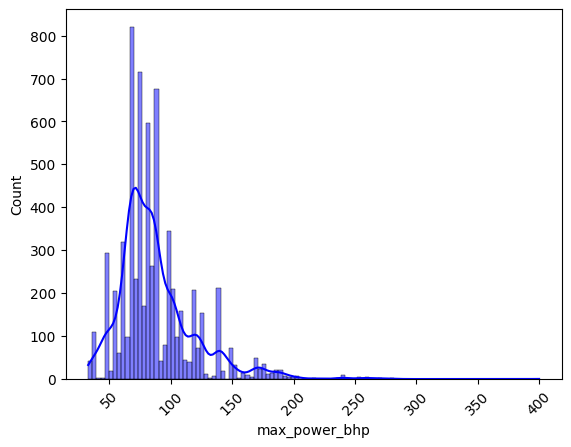

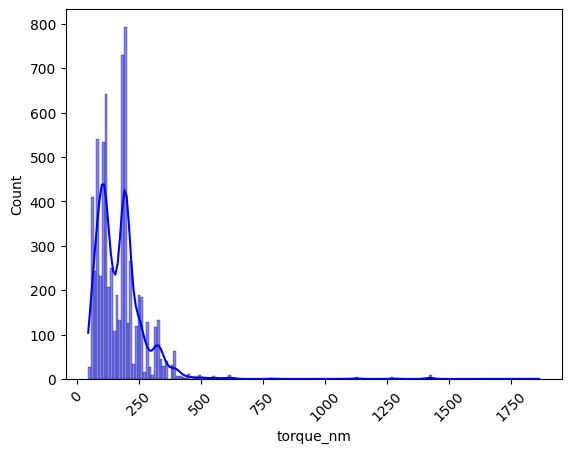

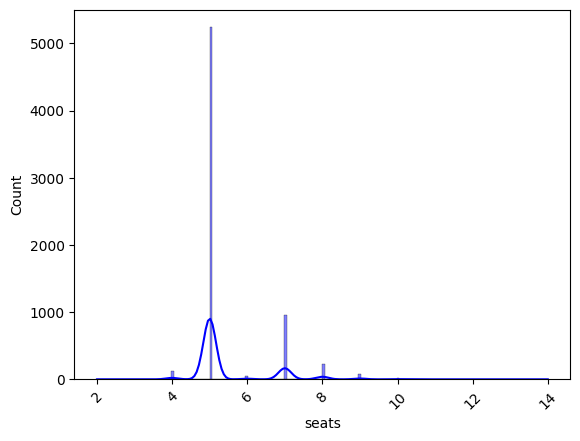

In [17]:
for col in num_cols:
    sns.histplot(x=col, data=df, kde=True, color='blue')
    plt.xticks(rotation=45)
    plt.show(block=True)

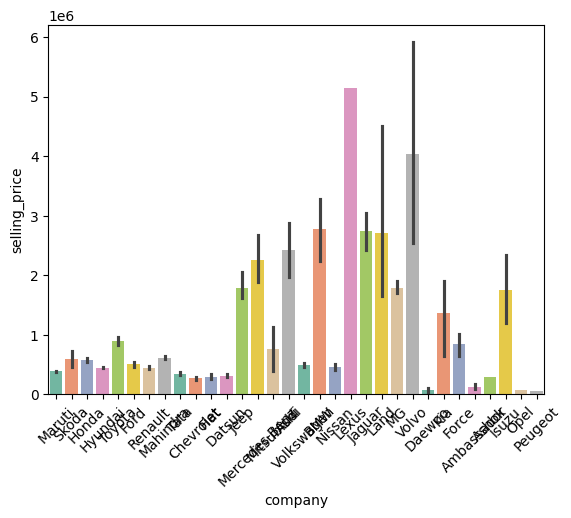

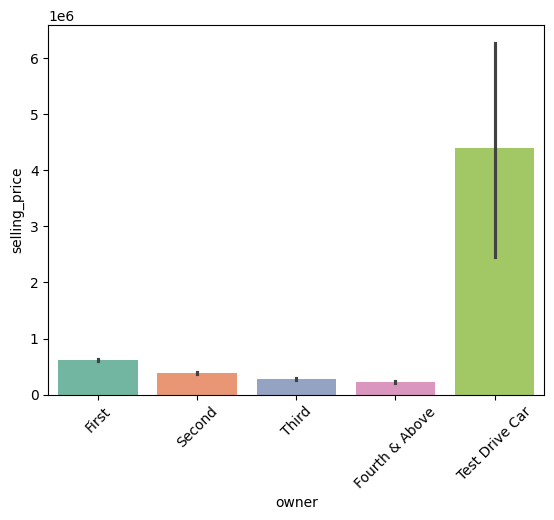

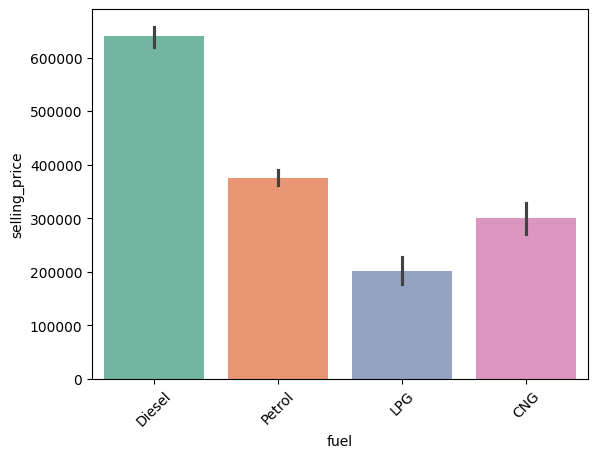

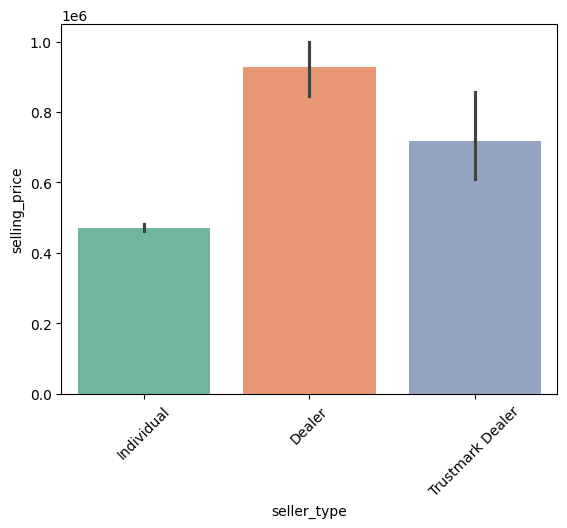

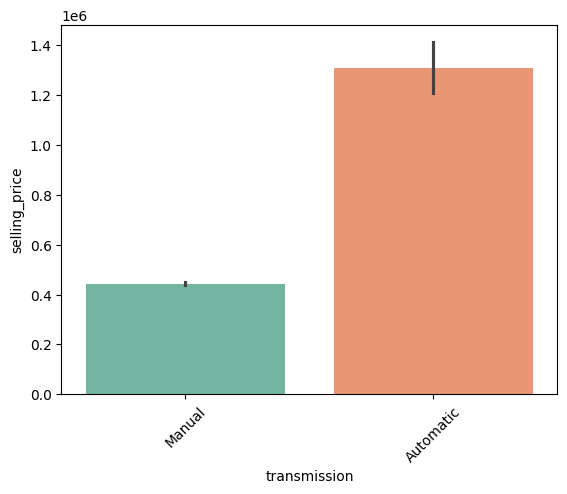

In [19]:
for col in cat_cols:
    sns.barplot(x=col, y='selling_price', data=df, palette="Set2", hue = col, legend=False)
    plt.xticks(rotation=45)
    plt.show(block=True)

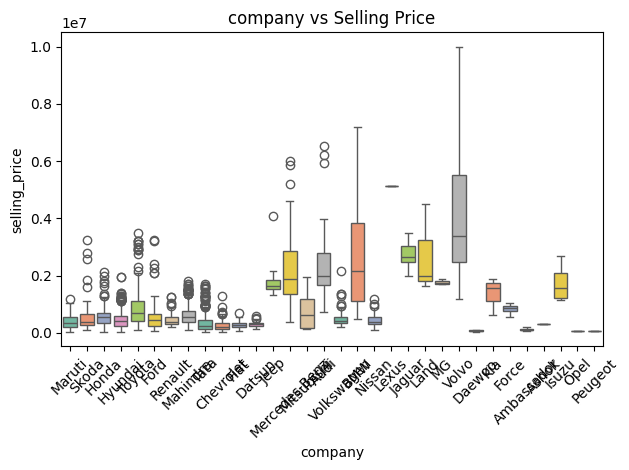

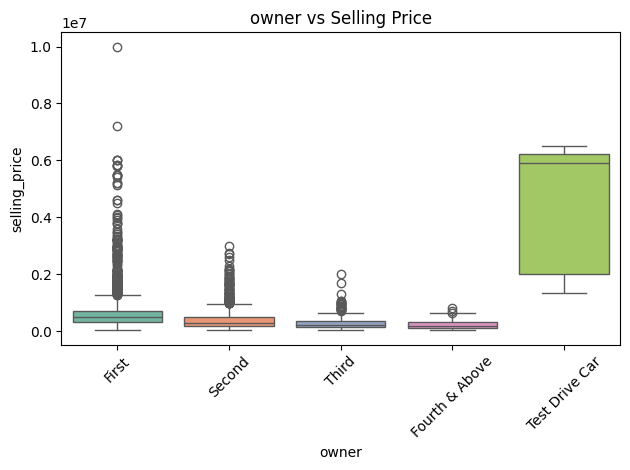

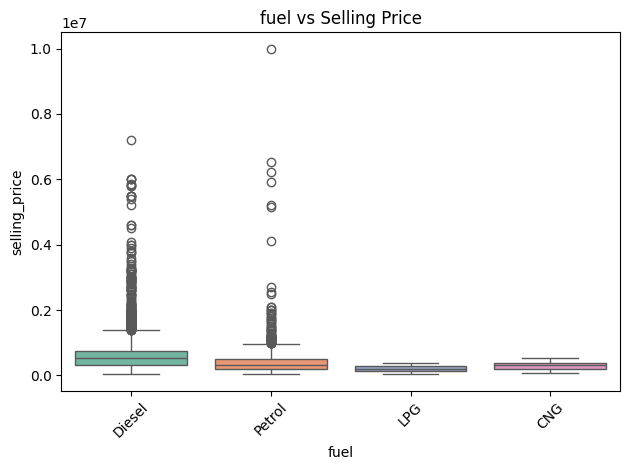

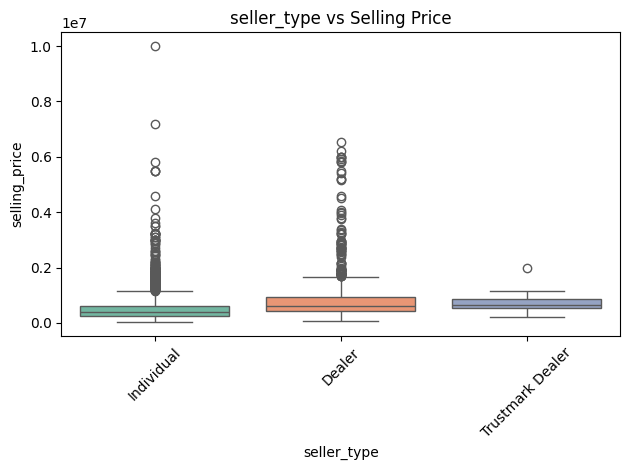

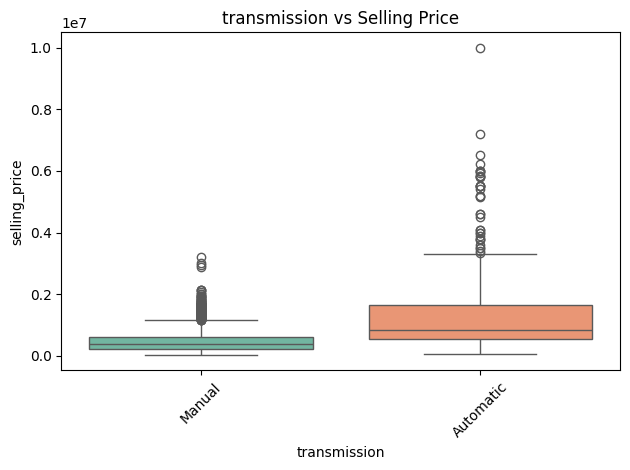

In [20]:
for col in cat_cols:
    sns.boxplot(x=col, y='selling_price', data=df, palette="Set2")
    plt.title(f"{col} vs Selling Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show(block=True)

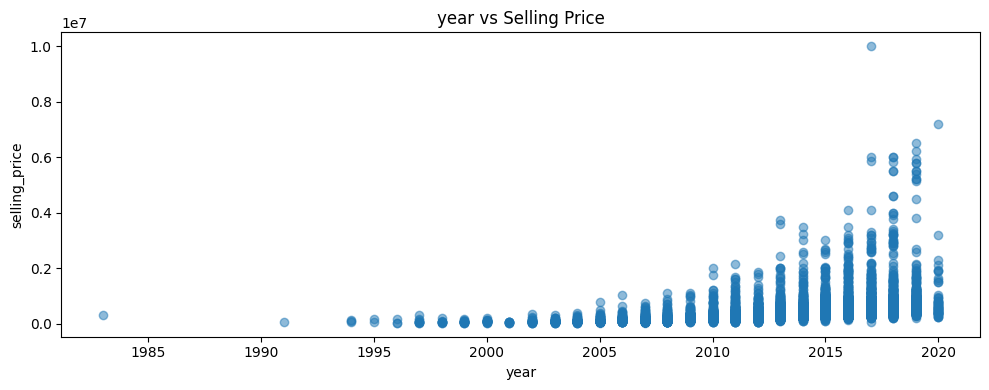

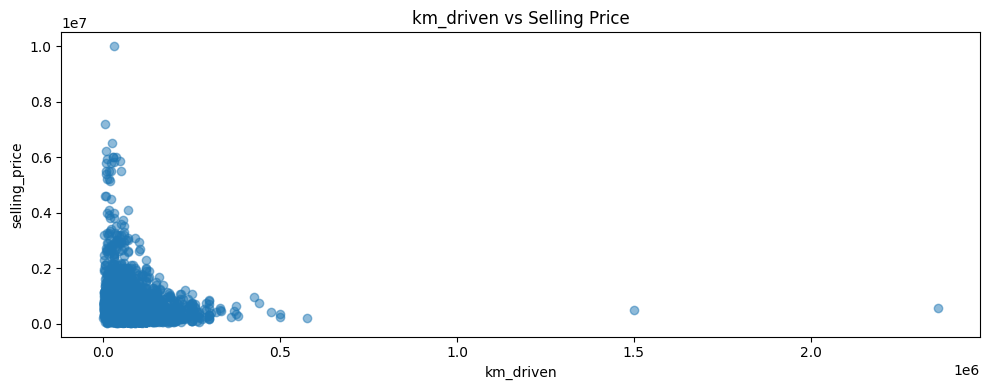

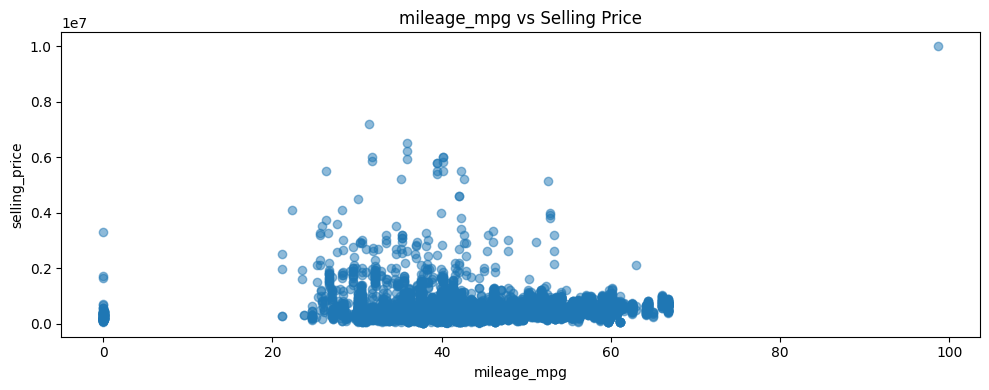

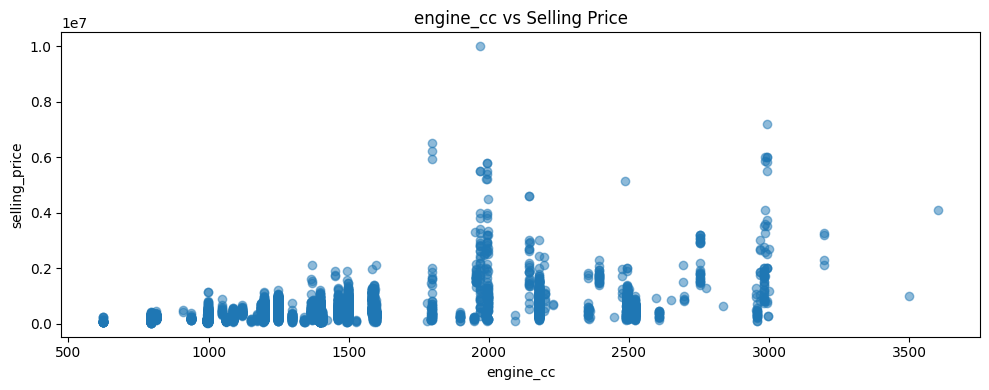

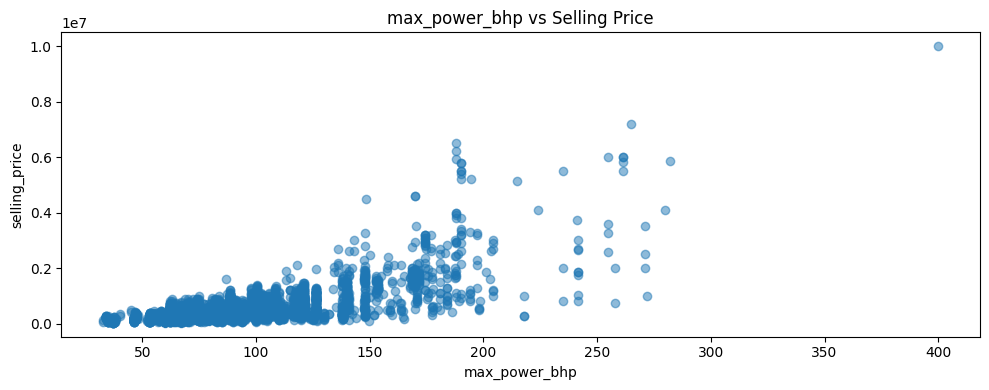

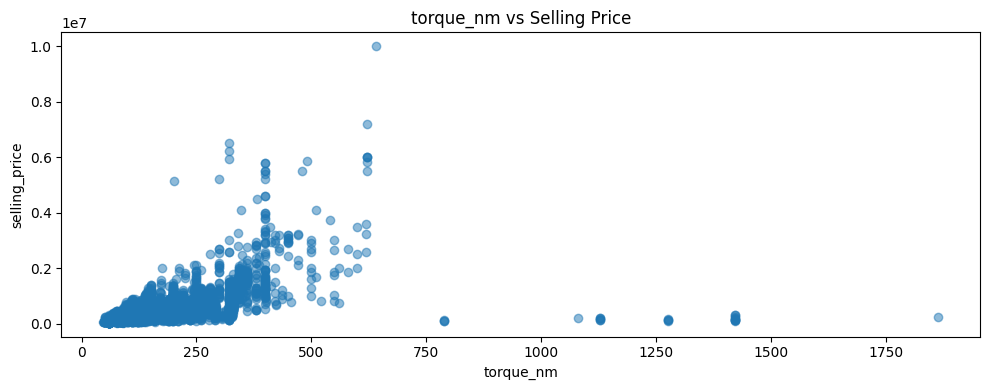

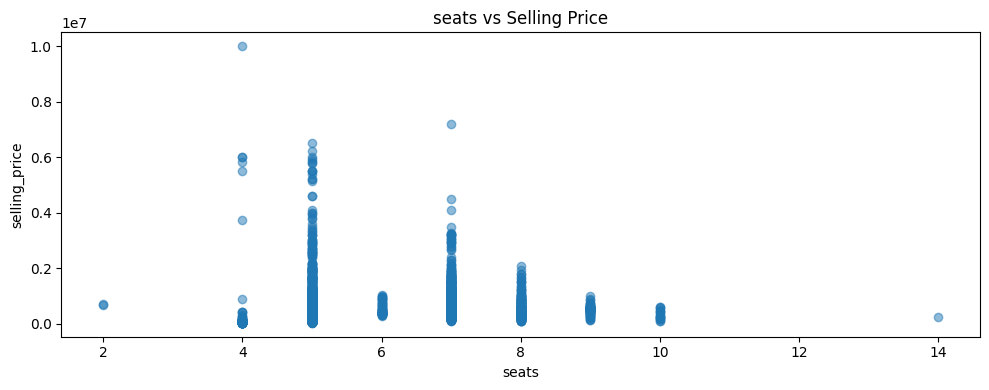

In [21]:
for col in num_cols:
    plt.figure(figsize=(10, 4))
    plt.scatter(df[col], df['selling_price'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('selling_price')
    plt.title(f"{col} vs Selling Price")
    plt.tight_layout()
    plt.show(block=True)

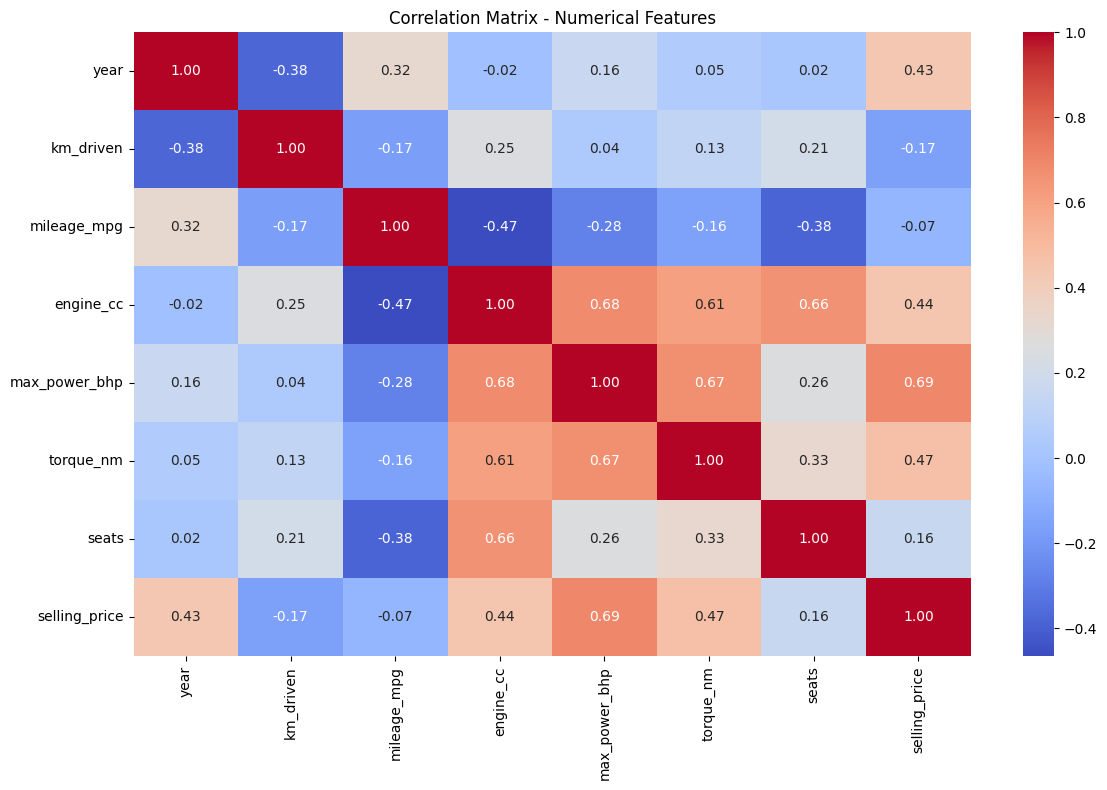

In [23]:
num_cols_corr = num_cols.copy()
num_cols_corr.append('selling_price')
corr_matrix = df[num_cols_corr].corr(method="pearson")

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Numerical Features")
plt.tight_layout()
plt.show(block=True)

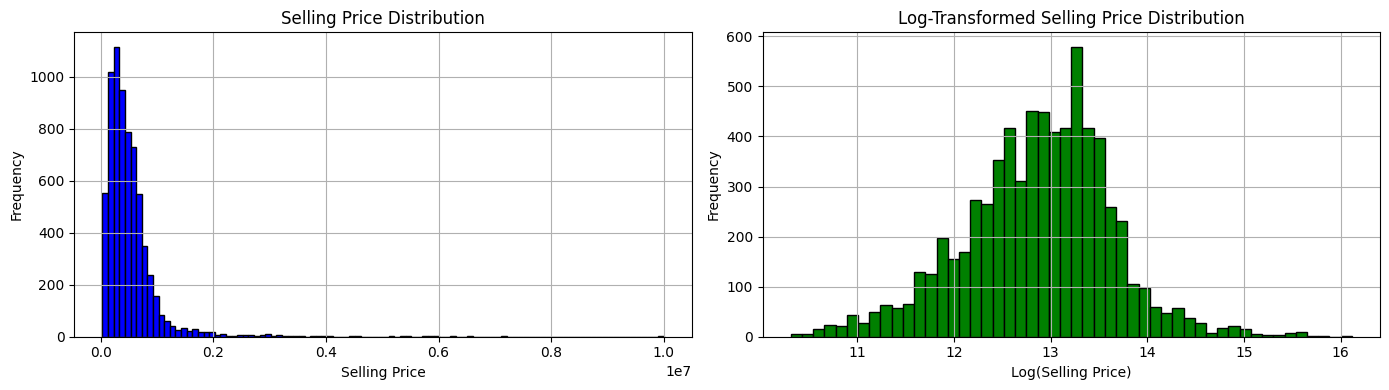

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Original distribution
df["selling_price"].hist(bins=100, ax=axes[0], color='blue', edgecolor='black')
axes[0].set_title("Selling Price Distribution")
axes[0].set_xlabel("Selling Price")
axes[0].set_ylabel("Frequency")

# Log-transformed distribution
np.log1p(df['selling_price']).hist(bins=50, ax=axes[1], color='green', edgecolor='black')
axes[1].set_title("Log-Transformed Selling Price Distribution")
axes[1].set_xlabel("Log(Selling Price)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show(block=True)

In [25]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.78):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [26]:
def check_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
print("Outlier Detection Results:")
print("=" * 50)
outlier_cols = []
for col in num_cols:
    has_outliers = check_outlier(df, col)
    print(f"{col}: {'Yes' if has_outliers else 'No'}")
    if has_outliers:
        outlier_cols.append(col)

print("\n" + "=" * 50)
print(f"Columns with outliers: {outlier_cols}")

Outlier Detection Results:
year: Yes
km_driven: Yes
mileage_mpg: Yes
engine_cc: Yes
max_power_bhp: Yes
torque_nm: Yes
seats: Yes

Columns with outliers: ['year', 'km_driven', 'mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'seats']


In [ ]:
def remove_outliers(dataframe, col_name):
    """Remove rows with outliers using IQR method"""
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] >= low_limit) & (dataframe[col_name] <= up_limit)]

df_cleaned = df.copy()
print(f"Original dataset shape: {df_cleaned.shape}")

for col in outlier_cols:
    df_cleaned = remove_outliers(df_cleaned, col)
    print(f"After removing outliers from {col}: {df_cleaned.shape}")

print(f"\nFinal cleaned dataset shape: {df_cleaned.shape}")
print(f"Rows removed: {df.shape[0] - df_cleaned.shape[0]}")

Original dataset shape: (6907, 13)
After removing outliers from year: (6830, 13)
After removing outliers from km_driven: (6717, 13)
After removing outliers from mileage_mpg: (6431, 13)
After removing outliers from engine_cc: (5535, 13)
After removing outliers from max_power_bhp: (5338, 13)
After removing outliers from torque_nm: (5314, 13)
After removing outliers from seats: (4819, 13)

Final cleaned dataset shape: (4819, 13)
Rows removed: 2088


In [32]:
X = df_cleaned.drop(columns='selling_price')
y = df_cleaned['selling_price'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (4819, 12)
Target shape: (4819,)


In [51]:
X = df.drop(columns='selling_price')
y = df['selling_price'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (6907, 12)
Target shape: (6907,)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Training set size: (5525, 12)
Test set size: (1382, 12)
Training target shape: (5525,)
Test target shape: (1382,)


In [53]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [ ]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Robust to outliers
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

Preprocessing pipeline created successfully!


In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'ElasticNet': ElasticNet(random_state=42),
        'KNN': KNeighborsRegressor(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
    }
    
    results = []
    trained_models = {}
    
    print("Training and Evaluating Models...")
    print("=" * 80)
    
    for model_name, model in models.items():
        start_time = time.time()
        
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        full_pipeline.fit(X_train, y_train)
        
        y_pred_train = full_pipeline.predict(X_train)
        y_pred_test = full_pipeline.predict(X_test)
        
        train_rmse = root_mean_squared_error(y_train, y_pred_train)
        test_rmse = root_mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        execution_time = time.time() - start_time
        
        results.append({
            'Model': model_name,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Time (s)': execution_time
        })
        
        trained_models[model_name] = full_pipeline
        
        print(f"\n{model_name}")
        print(f"  Train RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")
        print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
        print(f"  Train MAE: {train_mae:,.2f} | Test MAE: {test_mae:,.2f}")
        print(f"  Time: {execution_time:.2f}s")
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Test R²', ascending=False)
    
    print("\n" + "=" * 80)
    print("Model Rankings (by Test R² Score):")
    print("=" * 80)
    print(results_df[['Model', 'Train R²', 'Test R²', 'Test RMSE', 'Test MAE']].to_string(index=False))
    
    return results_df, trained_models

results_baseline, trained_models_baseline = train_and_evaluate_models(
    X_train, X_test, y_train, y_test, preprocessor
)

Training and Evaluating Models...

Linear Regression
  Train RMSE: 0.26 | Test RMSE: 0.26
  Train R²: 0.8832 | Test R²: 0.8840
  Train MAE: 0.20 | Test MAE: 0.20
  Time: 0.23s

Ridge
  Train RMSE: 0.26 | Test RMSE: 0.26
  Train R²: 0.8832 | Test R²: 0.8839
  Train MAE: 0.20 | Test MAE: 0.20
  Time: 0.07s

Lasso
  Train RMSE: 0.77 | Test RMSE: 0.75
  Train R²: 0.0000 | Test R²: -0.0000
  Train MAE: 0.60 | Test MAE: 0.58
  Time: 0.05s

ElasticNet
  Train RMSE: 0.74 | Test RMSE: 0.73
  Train R²: 0.0583 | Test R²: 0.0522
  Train MAE: 0.58 | Test MAE: 0.57
  Time: 0.05s

KNN
  Train RMSE: 0.22 | Test RMSE: 0.27
  Train R²: 0.9181 | Test R²: 0.8674
  Train MAE: 0.16 | Test MAE: 0.20
  Time: 0.21s

Decision Tree
  Train RMSE: 0.03 | Test RMSE: 0.30
  Train R²: 0.9983 | Test R²: 0.8430
  Train MAE: 0.01 | Test MAE: 0.21
  Time: 0.12s

Random Forest
  Train RMSE: 0.09 | Test RMSE: 0.22
  Train R²: 0.9865 | Test R²: 0.9132
  Train MAE: 0.06 | Test MAE: 0.16
  Time: 1.07s

Gradient Boosting
  Tra

In [ ]:
def hyperparameter_tune_and_evaluate(X_train, X_test, y_train, y_test, preprocessor):

    models_params = {
        'Ridge': (Ridge(random_state=42), {'regressor__alpha': [0.1, 1.0, 10.0]}),
        'Lasso': (Lasso(random_state=42), {'regressor__alpha': [0.001, 0.01, 0.1]}),
        'ElasticNet': (ElasticNet(random_state=42), {'regressor__alpha': [0.1, 1.0], 'regressor__l1_ratio': [0.2, 0.5, 0.8]}),
        'KNN': (KNeighborsRegressor(), {'regressor__n_neighbors': [3, 5, 7, 10]}),
        'Decision Tree': (DecisionTreeRegressor(random_state=42), {'regressor__max_depth': [5, 10, 15], 'regressor__min_samples_leaf': [1, 2, 4]}),
        'Random Forest': (RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), 
                         {'regressor__n_estimators': [50, 100, 150], 'regressor__max_depth': [10, 15, 20]}),
        'Gradient Boosting': (GradientBoostingRegressor(random_state=42), 
                             {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.01, 0.1]}),
        'XGBoost': (XGBRegressor(random_state=42, verbosity=0), 
                   {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.01, 0.1], 'regressor__max_depth': [5, 7]}),
        'LightGBM': (LGBMRegressor(random_state=42, verbose=-1), 
                    {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.01, 0.1]})
    }
    
    results = []
    best_models = {}
    best_params = {}
    
    print("Hyperparameter Tuning and Evaluation...")
    print("=" * 80)
    
    for model_name, (model, param_grid) in models_params.items():
        try:
            start_time = time.time()
            
            full_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', model)
            ])
            
            grid_search = GridSearchCV(
                full_pipeline, 
                param_grid=param_grid, 
                cv=5, 
                scoring='r2',
                n_jobs=-1
            )
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            y_pred_train = best_model.predict(X_train)
            y_pred_test = best_model.predict(X_test)
            
            train_rmse = root_mean_squared_error(y_train, y_pred_train)
            test_rmse = root_mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            train_mae = mean_absolute_error(y_train, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            execution_time = time.time() - start_time
            
            results.append({
                'Model': model_name,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Train R²': train_r2,
                'Test R²': test_r2,
                'Train MAE': train_mae,
                'Test MAE': test_mae,
                'Time (s)': execution_time,
                'Best CV Score': grid_search.best_score_
            })
            
            best_models[model_name] = best_model
            best_params[model_name] = grid_search.best_params_
            
            print(f"\n{model_name}")
            print(f"  Best Parameters: {grid_search.best_params_}")
            print(f"  Best CV Score: {grid_search.best_score_:.4f}")
            print(f"  Train RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")
            print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
            print(f"  Train MAE: {train_mae:,.2f} | Test MAE: {test_mae:,.2f}")
            print(f"  Time: {execution_time:.2f}s")
            
        except Exception as e:
            print(f"\n{model_name} - Error: {str(e)}")
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Test R²', ascending=False)
    
    print("\n" + "=" * 80)
    print("Tuned Model Rankings (by Test R² Score):")
    print("=" * 80)
    print(results_df[['Model', 'Train R²', 'Test R²', 'Test RMSE', 'Test MAE', 'Best CV Score']].to_string(index=False))
    
    return results_df, best_models, best_params

results_tuned, best_models, best_params = hyperparameter_tune_and_evaluate(
    X_train, X_test, y_train, y_test, preprocessor
)

Hyperparameter Tuning and Evaluation...

Ridge
  Best Parameters: {'regressor__alpha': 1.0}
  Best CV Score: 0.8774
  Train RMSE: 0.26 | Test RMSE: 0.26
  Train R²: 0.8832 | Test R²: 0.8839
  Train MAE: 0.20 | Test MAE: 0.20
  Time: 10.85s

Lasso
  Best Parameters: {'regressor__alpha': 0.001}
  Best CV Score: 0.8734
  Train RMSE: 0.27 | Test RMSE: 0.26
  Train R²: 0.8784 | Test R²: 0.8825
  Train MAE: 0.20 | Test MAE: 0.20
  Time: 0.24s

ElasticNet
  Best Parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.2}
  Best CV Score: 0.8180
  Train RMSE: 0.32 | Test RMSE: 0.32
  Train R²: 0.8216 | Test R²: 0.8196
  Train MAE: 0.24 | Test MAE: 0.25
  Time: 0.35s

KNN
  Best Parameters: {'regressor__n_neighbors': 7}
  Best CV Score: 0.8695
  Train RMSE: 0.23 | Test RMSE: 0.27
  Train R²: 0.9081 | Test R²: 0.8696
  Train MAE: 0.17 | Test MAE: 0.20
  Time: 0.78s

Decision Tree
  Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4}
  Best CV Score: 0.8795
  Tra

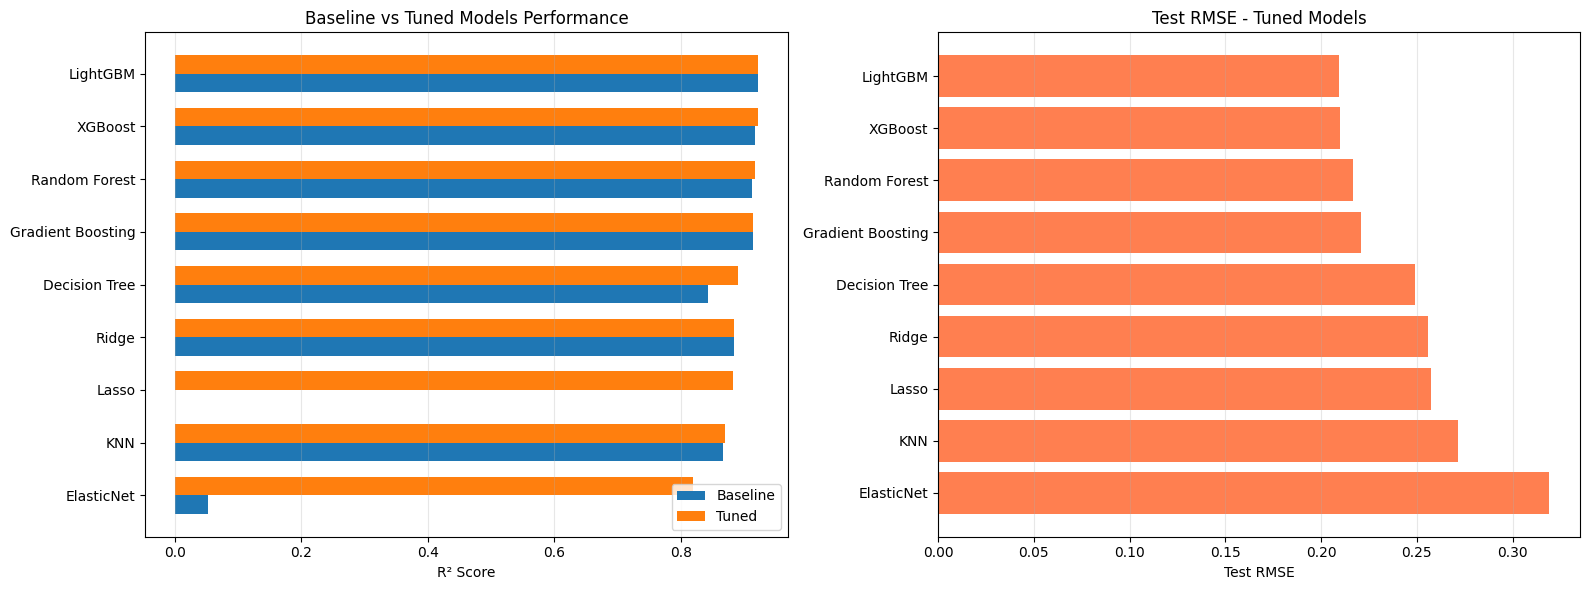


Comparison Summary:
            Model  Baseline R²  Tuned R²
       ElasticNet     0.052250  0.819590
              KNN     0.867377  0.869622
            Lasso    -0.000017  0.882513
            Ridge     0.883921  0.883921
    Decision Tree     0.843023  0.889982
Gradient Boosting     0.913531  0.913531
    Random Forest     0.913165  0.916686
          XGBoost     0.917121  0.922017
         LightGBM     0.922549  0.922549


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot baseline vs tuned comparison
comparison_data = results_baseline[['Model', 'Test R²']].copy()
comparison_data.columns = ['Model', 'Baseline R²']
tuned_data = results_tuned[['Model', 'Test R²']].copy()
tuned_data.columns = ['Model', 'Tuned R²']

comparison_merged = comparison_data.merge(tuned_data, on='Model', how='inner')
comparison_merged = comparison_merged.sort_values('Tuned R²', ascending=True)

x = np.arange(len(comparison_merged))
width = 0.35

axes[0].barh(x - width/2, comparison_merged['Baseline R²'], width, label='Baseline')
axes[0].barh(x + width/2, comparison_merged['Tuned R²'], width, label='Tuned')
axes[0].set_yticks(x)
axes[0].set_yticklabels(comparison_merged['Model'])
axes[0].set_xlabel('R² Score')
axes[0].set_title('Baseline vs Tuned Models Performance')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(comparison_merged['Model'], results_tuned.set_index('Model').loc[comparison_merged['Model'], 'Test RMSE'].values, color='coral')
axes[1].set_xlabel('Test RMSE')
axes[1].set_title('Test RMSE - Tuned Models')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show(block=True)

print("\nComparison Summary:")
print(comparison_merged.to_string(index=False))

In [ ]:
best_model_name = results_tuned.iloc[0]['Model']
best_model = best_models[best_model_name]
best_model_params = best_params[best_model_name]

print("=" * 80)
print(f"BEST MODEL: {best_model_name}")
print("=" * 80)
print(f"\nBest Hyperparameters: {best_model_params}")

best_model_metrics = results_tuned[results_tuned['Model'] == best_model_name].iloc[0]
print(f"\nBest Model Performance:")
print(f"  Train RMSE: {best_model_metrics['Train RMSE']:,.2f}")
print(f"  Test RMSE:  {best_model_metrics['Test RMSE']:,.2f}")
print(f"  Train R²:   {best_model_metrics['Train R²']:.4f}")
print(f"  Test R²:    {best_model_metrics['Test R²']:.4f}")
print(f"  Train MAE:  {best_model_metrics['Train MAE']:,.2f}")
print(f"  Test MAE:   {best_model_metrics['Test MAE']:,.2f}")
print("=" * 80)

BEST MODEL: LightGBM

Best Hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}

Best Model Performance:
  Train RMSE: 0.18
  Test RMSE:  0.21
  Train R²:   0.9462
  Test R²:    0.9225
  Train MAE:  0.13
  Test MAE:   0.15


In [ ]:
y_pred_train_best = best_model.predict(X_train)
y_pred_test_best = best_model.predict(X_test)

results_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred_test_best,
    'Absolute Error': np.abs(y_test.values - y_pred_test_best),
    'Percentage Error': (np.abs(y_test.values - y_pred_test_best) / y_test.values) * 100
})

results_df = results_df.sort_values('Absolute Error', ascending=False)

print("\nBest Model Predictions (Test Set):")
print("=" * 80)
print(results_df.head(10).to_string(index=False))
print(f"\n... ({len(results_df)} total predictions)")

print("\n" + "=" * 80)
print("Prediction Statistics:")
print(f"Mean Absolute Error: {results_df['Absolute Error'].mean():,.2f}")
print(f"Median Absolute Error: {results_df['Absolute Error'].median():,.2f}")
print(f"Mean Percentage Error: {results_df['Percentage Error'].mean():.2f}%")
print(f"Median Percentage Error: {results_df['Percentage Error'].median():.2f}%")
print("=" * 80)


Best Model Predictions (Test Set):
 Actual Price  Predicted Price  Absolute Error  Percentage Error
    12.611541        11.198068        1.413473         11.207773
    12.196027        11.271347        0.924681          7.581817
    11.385103        12.291434        0.906331          7.960672
    10.915107        11.813582        0.898476          8.231488
    11.461643        12.342442        0.880799          7.684754
    11.695255        10.862811        0.832444          7.117794
    10.950824        11.780570        0.829746          7.577019
    11.736077        12.490998        0.754921          6.432483
    13.190024        12.438747        0.751277          5.695799
    11.608245        12.306036        0.697791          6.011167

... (1382 total predictions)

Prediction Statistics:
Mean Absolute Error: 0.15
Median Absolute Error: 0.12
Mean Percentage Error: 1.23%
Median Percentage Error: 0.91%


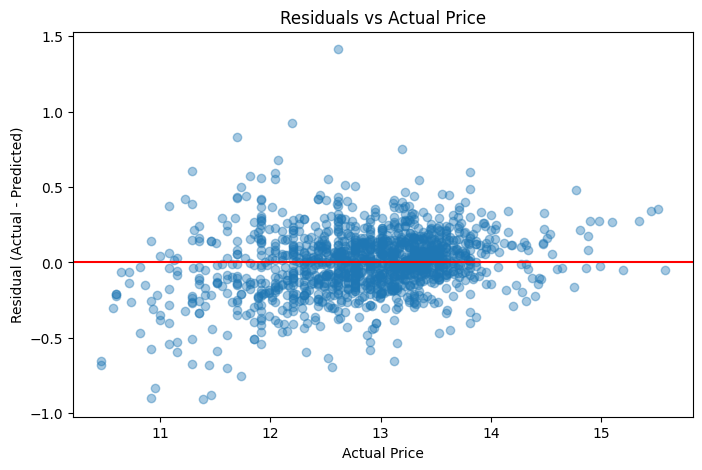

In [60]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test - y_pred_test_best, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Actual Price")
plt.show()